# MILB League Based Retention Model (QA)

* Stellar Algo
* Nakiska Rad & Ryan Kazmerik
* August 31, 2021

In [1]:
import getpass
import pyodbc
import pandas as pd
import numpy as np

import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')

## Let's get our dataset from MSSQL. We will select the full season product only and seasons before 2020, since 2020 was a strange year due to covid, and 2021 does not have any repurchasing data available

In [2]:
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
cursor = CNXN.cursor()

client_id = 11 #bulls
product = "Full Season"
train_season_year = 2019
test_season_year = 2021

query =  f"""
    SELECT 
        r.dimcustomermasterid,
        recency,
        attendancePercent,
        totalSpent,
        distToVenue,
        source_tenure,
        renewedBeforeDays,
        missed_games_1,
        missed_games_2,
        missed_games_over_2,
        isnextyear_buyer
    FROM 
        ds.retentionscoring r 
    WHERE 
        lkupclientid in(9,11,12,15,17,19,20,21,24,25,26,27,28,30,34,40,43,44,46,47,48,49,51,59) 
    AND 
        productgrouping = {"'"+ str(product) + "'"} 
    AND 
        year < {train_season_year};
    """
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dimcustomermasterid  17008 non-null  object
 1   recency              17008 non-null  int64 
 2   attendancePercent    17008 non-null  object
 3   totalSpent           17008 non-null  object
 4   distToVenue          17008 non-null  object
 5   source_tenure        17008 non-null  int64 
 6   renewedBeforeDays    17008 non-null  int64 
 7   missed_games_1       17008 non-null  int64 
 8   missed_games_2       17008 non-null  int64 
 9   missed_games_over_2  17008 non-null  int64 
 10  isnextyear_buyer     17008 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.4+ MB


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer
0,303661788,0,0.580986,2485,26.49,1460,8,8,8,3,1
1,303663474,1,0.527778,4032,23.92,1460,198,0,2,7,1
2,303659570,0,0.548611,1641.6,24.07,1460,185,14,4,3,1
3,303658983,3,0.313869,1561.8,18.21,1460,197,2,2,3,1
4,303659912,0,0.280992,1379.4,5.16,1460,202,0,0,4,1


## We need to hold back some samples from the dataset for evalution, so let's create the training and evaluation dataset with a hold-back of 10%.

In [4]:
df_train = df.sample(frac=0.8, random_state=786)
df_eval = df.drop(df_train.index)

print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape))

Data for Modeling: (15307, 11)
Unseen Data For Predictions: (1701, 11)


## Now we can model the data using PyCaret, with a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
model = setup(df_train, target='isnextyear_buyer', train_size = 0.8)

,Description,Value
0,session_id,2465
1,Target,isnextyear_buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(15307, 11)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


## Now we can compare all models to evaluate performance. This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) along with training time.

In [6]:
model_matrix = compare_models(fold=3, sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7927,0.8280,0.9445,0.7937,0.8625,0.4536,0.4834,12.6000
xgboost,Extreme Gradient Boosting,0.7969,0.8433,0.9141,0.8140,0.8611,0.4881,0.5000,42.2100
rf,Random Forest Classifier,0.7875,0.8123,0.9514,0.7855,0.8604,0.4317,0.4691,4.8400
lightgbm,Light Gradient Boosting Machine,0.7947,0.8469,0.9151,0.8112,0.8599,0.4808,0.4940,1.2733
ada,Ada Boost Classifier,0.7855,0.8151,0.9225,0.7978,0.8555,0.4471,0.4660,4.1000
et,Extra Trees Classifier,0.7733,0.7909,0.9403,0.7772,0.8510,0.3944,0.4278,9.4867
ridge,Ridge Classifier,0.7601,0.0000,0.8599,0.8049,0.8315,0.4164,0.4192,2.1867
dt,Decision Tree Classifier,0.7517,0.6973,0.8414,0.8064,0.8235,0.4052,0.4063,0.9633
knn,K Neighbors Classifier,0.7308,0.7342,0.8654,0.7716,0.8158,0.3223,0.3299,3.1533
lr,Logistic Regression,0.6885,0.4339,1.0000,0.6885,0.8155,0.0000,0.0000,1.9900


## Now we can create the best model based on performance and train and evaluate the model. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold which by default is set to 10.

In [7]:
best_model = create_model(model_matrix)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7902,0.8317,0.9491,0.7892,0.8618,0.4418,0.4758
1,0.7910,0.8359,0.9514,0.7886,0.8624,0.4438,0.4794
2,0.7927,0.8212,0.9526,0.7896,0.8634,0.4482,0.4841
3,0.8000,0.8336,0.9431,0.8014,0.8665,0.4784,0.5044
4,0.7910,0.8420,0.9514,0.7886,0.8624,0.4438,0.4794
5,0.7794,0.8122,0.9265,0.7897,0.8526,0.4252,0.4473
6,0.7851,0.8302,0.9336,0.7918,0.8568,0.4378,0.4626
7,0.8080,0.8453,0.9490,0.8065,0.8719,0.4985,0.5258
8,0.8015,0.8381,0.9229,0.8138,0.8649,0.4960,0.5102
9,0.7998,0.8267,0.9395,0.8032,0.8660,0.4796,0.5034


## Now let's tune the model. In order to tune hyperparameters, the tune_model function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

In [17]:
tuned_model = tune_model(best_model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7861,0.8048,0.9396,0.7898,0.8582,0.4360,0.4644
1,0.7894,0.7962,0.9419,0.7916,0.8602,0.4458,0.4747
2,0.7812,0.8042,0.9431,0.7833,0.8558,0.4187,0.4513
3,0.7845,0.8161,0.9288,0.7933,0.8557,0.4402,0.4622
4,0.7861,0.8056,0.9359,0.7914,0.8576,0.4399,0.4659
5,0.7786,0.7876,0.9265,0.7889,0.8522,0.4226,0.4450
6,0.7802,0.7951,0.9193,0.7941,0.8521,0.4332,0.4513
7,0.7810,0.8240,0.9229,0.7931,0.8531,0.4331,0.4528
8,0.7966,0.8233,0.9253,0.8075,0.8624,0.4795,0.4962
9,0.7990,0.8037,0.9359,0.8043,0.8651,0.4796,0.5015


## Let's plot the feature importance. The plot_model() function can be used to analyze the  feature Importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

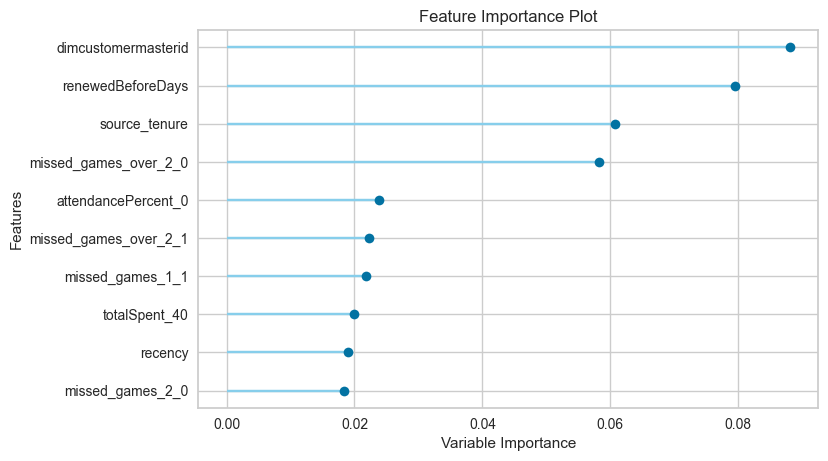

In [18]:
plot_model(tuned_model, plot='feature')

## Now we can predict on the test / evaluation sample. Before finalizing the model, it is advisable to perform one final check by predicting the test/evaluation set and reviewing the evaluation metrics.

In [19]:
predict_model(final_model)

unseen_predictions = predict_model(final_model, data=df_eval)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8018,0.8595,0.9486,0.7963,0.8658,0.4975,0.5264


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer,Label,Score
5,272911264,0,0.378472,2088,4.02,1460,23,3,2,7,1,1,0.6885
8,272847802,0,0.506944,2304,7.82,1460,14,1,6,7,1,1,0.6578
12,272886233,6,0.376736,4608,19.32,1460,15,0,0,7,1,1,0.5923
18,272879943,0,0.439189,6340.32,26.49,824,72,0,0,1,0,1,0.6766
20,272829320,1,0.409253,2248,23.92,458,191,4,1,7,0,1,0.7595


## Let's finalize the model for deployment. The finalize_model() function fits the model onto the complete dataset including the test/evaluation sample (10% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [20]:
final_model = finalize_model(best_model)

print(final_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2465, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## We can now save the final model. PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.

In [21]:
save_model(final_model,'QA-MILB-Team-Based-Retention-Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='isnextyear_buyer',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 num...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
           

## Now that we have an exported model we can use it to score new data. To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.

In [22]:
saved_final_model = load_model('QA-MILB-Team-Based-Retention-Model')

new_prediction = predict_model(saved_final_model, data=df_eval)
new_prediction.head()

Transformation Pipeline and Model Successfully Loaded


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer,Label,Score
5,272911264,0,0.378472,2088,4.02,1460,23,3,2,7,1,1,0.6885
8,272847802,0,0.506944,2304,7.82,1460,14,1,6,7,1,1,0.6578
12,272886233,6,0.376736,4608,19.32,1460,15,0,0,7,1,1,0.5923
18,272879943,0,0.439189,6340.32,26.49,824,72,0,0,1,0,1,0.6766
20,272829320,1,0.409253,2248,23.92,458,191,4,1,7,0,1,0.7595
